In [1]:
import math
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
yf.pdr_override()

In [13]:
data = pdr.get_data_yahoo('AAPL',start='2012-01-01', end='2022-01-01')

[*********************100%***********************]  1 of 1 completed


In [14]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.500192,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.567369,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.706894,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.839727,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.819361,394024400
...,...,...,...,...,...,...
2021-12-27,177.089996,180.419998,177.070007,180.330002,179.016129,74919600
2021-12-28,180.160004,181.330002,178.529999,179.289993,177.983673,79144300
2021-12-29,179.330002,180.630005,178.139999,179.380005,178.073044,62348900


In [106]:
data.shape

(2517, 6)

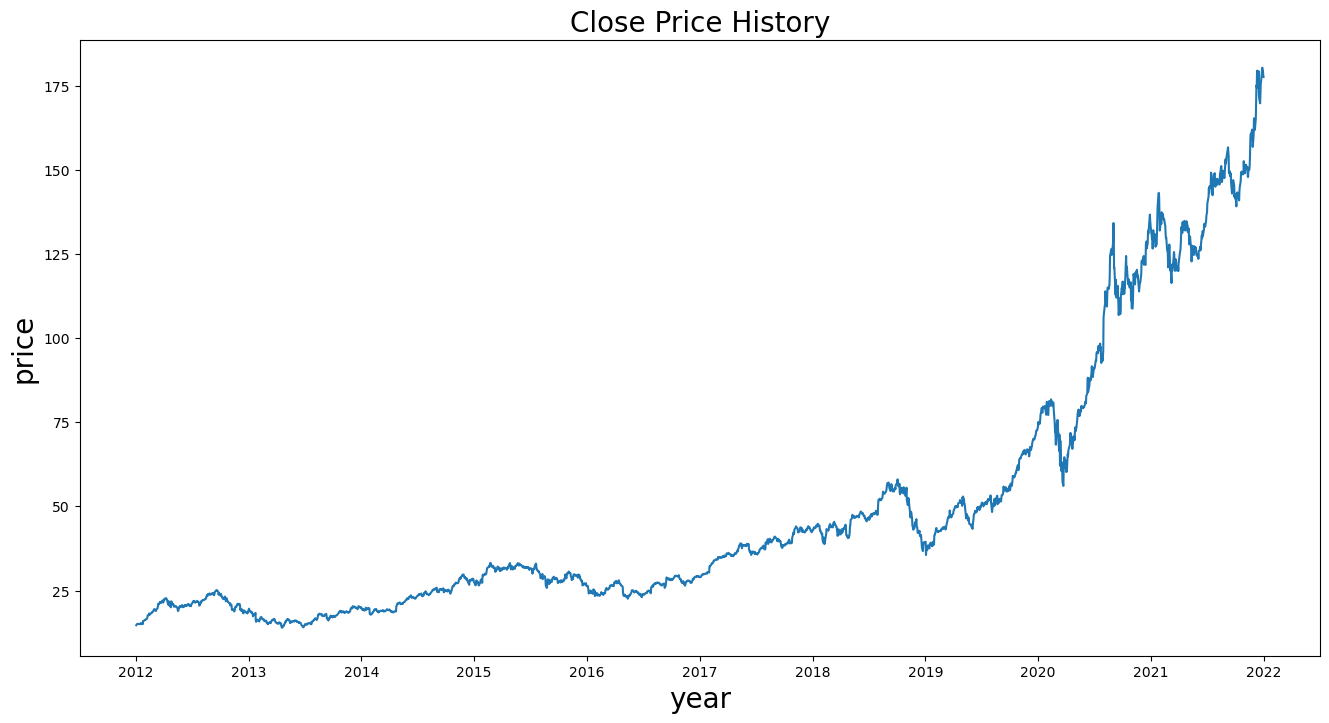

In [26]:
plt.figure(figsize=(16,8))
plt.title('Close Price History',fontsize=20)
plt.plot(data['Close'])
plt.xlabel('year',fontsize=20)
plt.ylabel('price',fontsize=20)
plt.show()

In [43]:
closed_data = data['Close']

In [53]:
closed_data = np.array(closed_data).reshape(-1,1)

In [54]:
training_data_len = math.ceil(len(closed_data) * 0.8)

In [112]:
training_data_len

2014

In [161]:
closed_data

array([[ 14.6867857 ],
       [ 14.76571369],
       [ 14.92964268],
       ...,
       [179.38000488],
       [178.19999695],
       [177.57000732]])

In [55]:
scaler = MinMaxScaler(feature_range=(0,1))

In [56]:
scaled_data = scaler.fit_transform(closed_data)

In [108]:
scaled_data.shape

(2517, 1)

   ## create the training data set

In [59]:
train_data = scaled_data[0:training_data_len, :]

In [67]:
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

## 

In [68]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [70]:
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))

In [71]:
x_train.shape

(1954, 60, 1)

## model

In [98]:
model = Sequential()

In [99]:
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [104]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [105]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1954/1954 [==============================] - 66s 31ms/step - loss: 1.6798e-04


## Creating testing DataSet

In [116]:
test_data = scaled_data[training_data_len - 60:2517, :]
x_test = []
y_test = closed_data[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [117]:
x_test = np.array(x_test)

In [119]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1))

In [120]:
predictions = model.predict(x_test)

16/16 [==============================] - 3s 30ms/step


In [121]:
predictions = scaler.inverse_transform(predictions)

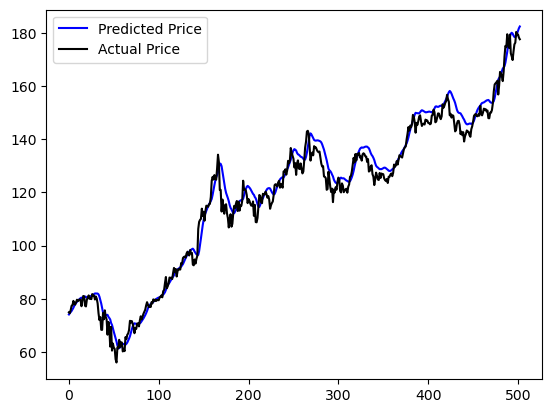

In [124]:
plt.plot(predictions, color='blue', label='Predicted Price')
plt.plot(y_test, color='black', label='Actual Price')
plt.legend()
plt.show()

In [125]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1.8646388726964385

In [147]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions


C:\Users\shoai\AppData\Local\Temp\ipykernel_10608\3011436284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


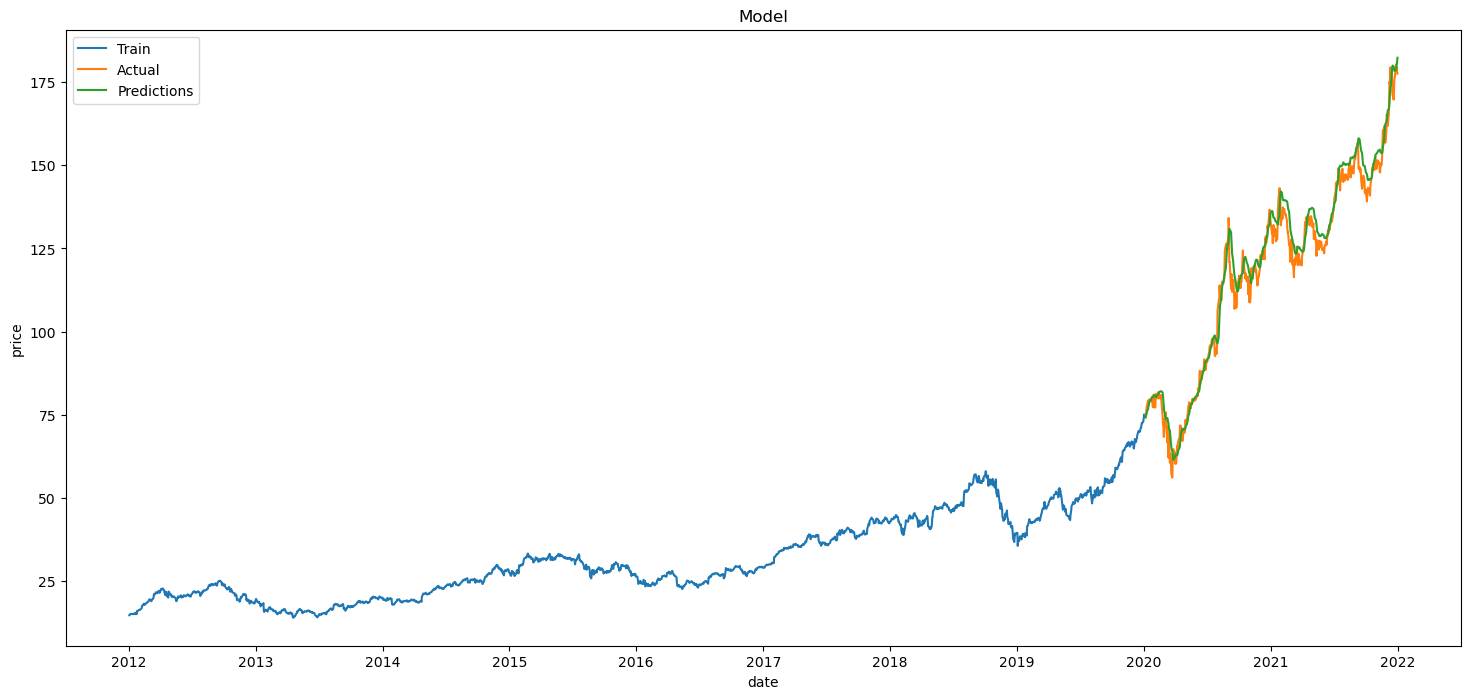

In [139]:
plt.figure(figsize=(18,8))
plt.title('Model')
plt.xlabel('date')
plt.ylabel('price')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'],)

plt.show()

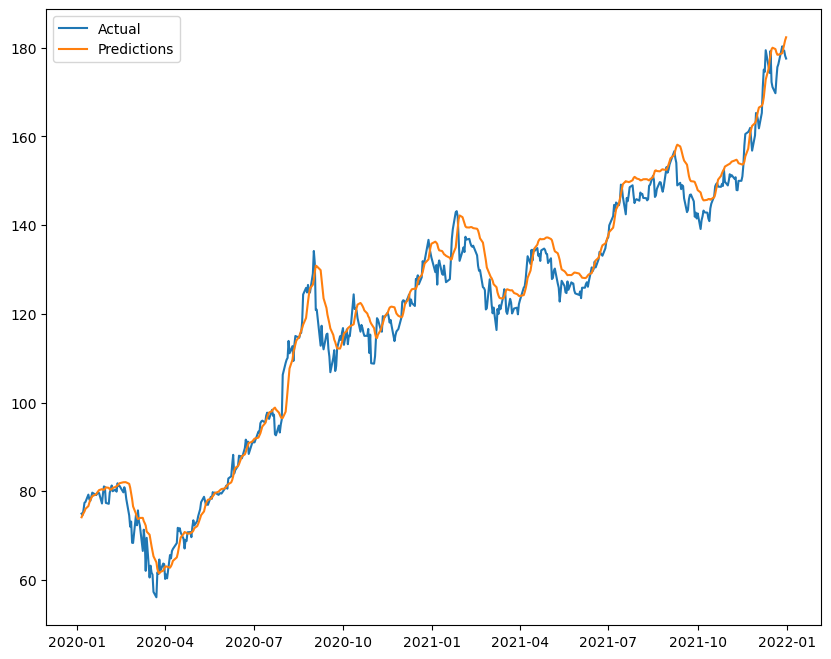

In [137]:
plt.figure(figsize=(10,8))
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Actual', 'Predictions'],)
plt.show()

In [148]:
valid 

,Open,High,Low,Close,Adj Close,Volume,Predictions
Date,,,,,,,
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.314888,118387200,74.132011
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.970070,108872000,74.636520
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.143906,132079200,75.023605
2020-01-09,76.809998,77.607498,76.550003,77.407501,75.718781,170108400,75.448639
2020-01-10,77.650002,78.167503,77.062500,77.582497,75.889961,140644800,76.033348
...,...,...,...,...,...,...,...
2021-12-27,177.089996,180.419998,177.070007,180.330002,179.016129,74919600,178.761887
2021-12-28,180.160004,181.330002,178.529999,179.289993,177.983673,79144300,179.725327
2021-12-29,179.330002,180.630005,178.139999,179.380005,178.073044,62348900,180.750778


In [ ]:
#apple_data = pdr.get_data_yahoo('AAPL', start='2012-01-01', end='2023-03-02')
apple_data = pdr.get_data_yahoo('AAPL', start='2017-01-01', end='2023-03-02')

In [200]:
new_df = apple_data['Close']
new_df_60 = new_df[-60:].values
new_df_60 = new_df_60.reshape(-1,1)

In [201]:
new_df_60_scaled = scaler.transform(new_df_60)

In [202]:
x_test1 = []

In [203]:
x_test1.append(new_df_60_scaled)
x_test1 = np.array(x_test1)
x_test1 = np.reshape(x_test1, (x_test1.shape[0], x_test1.shape[1], 1))

In [204]:
pred_price = model.predict(x_test1)

1/1 [==============================] - 0s 70ms/step


In [205]:
pred_price = scaler.inverse_transform(pred_price)

In [206]:
pred_price

array([[176.89342]], dtype=float32)